# This notebook is designed to assess functional differences between two groups of MAGs, eg those that belong to "treatment" and "control" groups. 

# To do this, you will take MAG-specific KO annotations for each group and identify genes that differ significantly between the two groups. 

# To run it, you will need KofamScan output files for each MAG, allocated to two directories according to group. You will also need the "master" KO file. Instructions for generating this file or downloading it are here: http://merenlab.org/2018/01/17/importing-ghostkoala-annotations/

In [1]:
import os as os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob as glob
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection

### Function to import kofamscan outputs for each MAG, remove empty rows, and add a column with the MAG name

In [2]:
def make_mag_ko_matrix(file):
    a, b = file.split('.')
    c, d, e, f, g = a.split('_')
    name = c + '_' + d + '_' + e
    ko = pd.read_csv(file, sep='\t', names=['ORF', 'KO'])
    ko_mag = pd.DataFrame(ko['KO'])
    ko_mag.dropna(inplace=True)
    ko_mag['MAG'] = name
    return(ko_mag)

### Navigate to directory with first group of kofamscan outputs (eg MAGs in the "control" group).

In [3]:
os.chdir('/Users/npatin3/Desktop/GTPostdoc/Noro_Assemblies/mags/Group2_kofams')

### Loop through all kofamscan outputs and concatenate them into one file with MAG-specific column included

In [4]:
ko_mags_all2 = []
for file in glob.glob("*.txt"):
    x = make_mag_ko_matrix(file)
    ko_mags_all2.append(x)
    
ko_mags_all2 = pd.concat(ko_mags_all2)
ko_mags_all2.head()

,KO,MAG
2,K18929,36_12_003
3,K18928,36_12_003
4,K02469,36_12_003
8,K06113,36_12_003
10,K00208,36_12_003


### Reformat the data frame for the heat map

In [5]:
df2 = pd.pivot_table(data=ko_mags_all2, index='MAG',columns='KO',aggfunc=len).fillna(0)
df2.head()

KO,K00003,K00005,K00009,K00010,K00012,K00013,K00014,K00016,K00018,K00024,...,K23393,K23475,K23508,K23509,K23514,K23518,K23535,K23536,K23537,K23573
MAG,,,,,,,,,,,,,,,,,,,,,
13_1_001,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14_1_002,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15_1_010,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
15_1_014,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
15_1_015,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Drop all columns containing only zeros

In [6]:
df2 = df2.loc[:, (df2 != 0).any(axis=0)]

### If needed, go to a different directory and import the next group of MAG-specific kofams

In [7]:
os.chdir('/Users/npatin3/Desktop/GTPostdoc/Noro_Assemblies/mags/Group1_kofams')

### Now we can do the same process for the second group of MAGs ("treatment").

In [8]:
ko_mags_all1 = []
for file in glob.glob("*kofams.txt"):
    x = make_mag_ko_matrix(file)
    ko_mags_all1.append(x)
    
ko_mags_all1 = pd.concat(ko_mags_all1)
ko_mags_all1.head()

,KO,MAG
1,K07030,38_6_017
4,K00962,38_6_017
5,K02956,38_6_017
6,K03310,38_6_017
7,K07979,38_6_017


In [9]:
df1 = pd.pivot_table(data=ko_mags_all1, index='MAG',columns='KO',aggfunc=len).fillna(0)
df1.head()

KO,K00003,K00005,K00012,K00013,K00014,K00016,K00018,K00020,K00027,K00029,...,K23393,K23398,K23509,K23514,K23518,K23535,K23536,K23537,K23541,K23573
MAG,,,,,,,,,,,,,,,,,,,,,
15_3_004,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0
15_3_006,1.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0
15_6_004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
15_6_011,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15_8_002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Merge the two group ("treatment" vs "control") data frames

In [10]:
df_both = pd.concat([df1, df2]).fillna(0)
df_both.shape

(39, 3646)

### Drop columns in which every row (MAG) has the same value

In [11]:
nunique = df_both.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
df_both = df_both.drop(cols_to_drop, axis=1)

In [12]:
df_both.shape

(39, 3645)

#### Looks like we only lost one gene here

### Check out overall range of total number of genes across all MAGs

In [13]:
s = df_both.sum(axis=0).sort_values(ascending=False, inplace=False)
s 

K21572    541.0
K03327    309.0
K02004    251.0
K02014    191.0
K10822    169.0
          ...  
K03597      1.0
K03598      1.0
K03599      1.0
K03600      1.0
K17234      1.0
Length: 3645, dtype: float64

### This is a big range! A t-test should work well to test differences across two groups

In [14]:
# Save data frame with values if you like
df_both.to_csv("MAG_KOs_bothgroups.csv")

## Calculate fold change and run t-tests on genes in increase MAGs / decrease MAGs 

### Add two new rows for statistical results

In [15]:
df_ttest = df_both.append(pd.Series(name='ttest', dtype='int'))
df_ttest = df_ttest.append(pd.Series(name='p-value', dtype='int'))
df_ttest = df_ttest.append(pd.Series(name='corrected_p-value', dtype='int'))
df_ttest.tail()

,K00003,K00005,K00012,K00013,K00014,K00016,K00018,K00020,K00027,K00029,...,K23265,K23270,K23300,K23301,K23302,K23303,K23349,K23356,K23475,K23508
MAG,,,,,,,,,,,,,,,,,,,,,
4_1_004,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4_4_014,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ttest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p-value,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
corrected_p-value,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Fill new rows with results of scipy t-tests

In [16]:
df_ttest.iloc[39] = ttest_ind(df_ttest.iloc[:13, :], df_ttest.iloc[13:39, :], usevar='unequal', value=0)[0]
df_ttest.iloc[40] = ttest_ind(df_ttest.iloc[:13, :], df_ttest.iloc[13:39, :], usevar='unequal', value=0)[1]
df_ttest.iloc[41] = fdrcorrection(df_ttest.iloc[40], alpha=0.1, method='indep')[1]
df_ttest.tail()

,K00003,K00005,K00012,K00013,K00014,K00016,K00018,K00020,K00027,K00029,...,K23265,K23270,K23300,K23301,K23302,K23303,K23349,K23356,K23475,K23508
MAG,,,,,,,,,,,,,,,,,,,,,
4_1_004,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4_4_014,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ttest,1.334686,0.881591,-2.897914,-3.337119,0.147122,-0.239732,-2.002474,1.477098,0.899843,-2.480695,...,-1.000000,-1.000000,-1.000000,-1.443376,-1.000000,-1.000000,-1.443376,-1.000000,-1.000000,-1.000000
p-value,0.194754,0.392357,0.006440,0.002820,0.885068,0.812238,0.055083,0.165407,0.377901,0.017867,...,0.326892,0.326892,0.326892,0.161329,0.326892,0.326892,0.161329,0.326892,0.326892,0.326892
corrected_p-value,0.449358,0.512228,0.089251,0.055458,0.925437,0.866704,0.334072,0.449358,0.496557,0.170932,...,0.449358,0.449358,0.449358,0.449358,0.449358,0.449358,0.449358,0.449358,0.449358,0.449358


### Function to calculate fold difference between asymptomatic and symptomatic samples

In [17]:
def fold_difference(df, num_symp_rows, num_sample_rows):
    set1 = df.iloc[0:num_symp_rows]
    set2 = df.iloc[num_symp_rows:num_sample_rows]
    mean_diff = np.mean(set1) / np.mean(set2)
    #print(mean_diff)
    return(mean_diff)

### Apply function to data frame to calculate fold difference of each column

In [18]:
df_ttest = df_ttest.replace(0, 0.000000001)
df_ttest.loc['fold change'] = fold_difference(df_ttest, 13, 39)
df_ttest.head()

,K00003,K00005,K00012,K00013,K00014,K00016,K00018,K00020,K00027,K00029,...,K23265,K23270,K23300,K23301,K23302,K23303,K23349,K23356,K23475,K23508
MAG,,,,,,,,,,,,,,,,,,,,,
15_3_004,1.000000e+00,1.000000e-09,1.000000e-09,1.000000e+00,1.000000e+00,1.000000e-09,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e-09,...,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09
15_3_006,1.000000e+00,1.000000e-09,1.000000e-09,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e-09,1.000000e+00,1.000000e-09,...,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09
15_6_004,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,...,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09
15_6_011,1.000000e+00,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e+00,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,...,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09
15_8_002,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,...,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09


### Select only KOs that are significantly different between the groups, with a corrected p-value < 0.05

In [19]:
kos_signif = df_ttest.loc[:, df_ttest.loc['corrected_p-value'] < 0.05]
kos_signif.shape

(43, 166)

In [20]:
kos_signif.tail()

,K00174,K00175,K00177,K00262,K00278,K00548,K00566,K00661,K00748,K00845,...,K12524,K13043,K15977,K16053,K16363,K18691,K18929,K19222,K19802,K21572
MAG,,,,,,,,,,,,,,,,,,,,,
4_4_014,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000e-09,2.000000,...,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09
ttest,-4.225771,-3.731967,-3.594078,-3.701166,-3.992918,-4.221875,3.992918,-4.479173,-3.992918e+00,-3.651867,...,-3.638034e+00,-4.281744e+00,-3.638034e+00,-3.875131e+00,-3.952847e+00,-4.319342e+00,-3.638034e+00,-3.638034e+00,-4.281744e+00,-3.604882e+00
p-value,0.000151,0.000638,0.001042,0.000771,0.000302,0.000289,0.000302,0.000100,3.023379e-04,0.001023,...,1.247050e-03,2.396480e-04,1.247050e-03,6.822968e-04,5.591738e-04,2.174415e-04,1.247050e-03,1.247050e-03,2.396480e-04,1.355995e-03
corrected_p-value,0.009469,0.021139,0.029224,0.024261,0.012382,0.012382,0.012382,0.007273,1.238227e-02,0.028895,...,3.102569e-02,1.105718e-02,3.102569e-02,2.220510e-02,1.887212e-02,1.105718e-02,3.102569e-02,3.102569e-02,1.105718e-02,3.209481e-02
fold change,0.193548,0.230769,0.222222,0.375000,0.133333,0.344828,1.866667,0.095238,1.333333e-01,0.378378,...,2.888889e-09,2.363636e-09,2.166667e-09,1.368421e-09,2.600000e-09,1.300000e-09,2.888889e-09,2.888889e-09,2.363636e-09,4.805915e-11


### Save just the list of significantly different KOs

In [21]:
ko_sd_list = list(kos_signif.columns)

In [37]:
with open("MAG_SDKOs_CORRECTED_p05_list.txt", "w") as output:
    output.write(str(ko_sd_list))

# Get annotations of significantly different KOs

### Import the "master" KO htext file

In [23]:
ko_master = '/Users/npatin3/Desktop/GTPostdoc/Noro_Assemblies/KO_Orthology_ko00001.txt'

### Match the KO number in column 3 of the master file with the KO list

In [24]:
# KO list
kos_unfilt = df_both.columns.to_list()

In [26]:
with open(ko_master, 'r') as file, open('MAG_KOs_fxns_unfilt.tsv', 'w') as outfile:
    for line in file:
        X = line.rstrip().split('\t')
        konumber = X[3].split(' ')[0]
        if konumber in kos_unfilt:
            outfile.write(line)

In [28]:
kos = pd.read_csv('MAG_KOs_fxns_unfilt.tsv', names=['Group','Subgroup1','Subgroup2','KO'], sep='\t')
kos.head()

,Group,Subgroup1,Subgroup2,KO
0,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],K00844 HK; hexokinase [EC:2.7.1.1]
1,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],K00845 glk; glucokinase [EC:2.7.1.2]
2,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],"K01810 GPI, pgi; glucose-6-phosphate isomeras..."
3,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],"K06859 pgi1; glucose-6-phosphate isomerase, a..."
4,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],"K00850 pfkA, PFK; 6-phosphofructokinase 1 [EC..."


In [29]:
kos.shape

(6197, 4)

### Exclude all irrelevant KEGG categories

In [30]:
searchfor = ['Human Diseases','Brite Hierarchies','Organismal Systems',
                                    'Cellular community - eukaryotes']
kos2 = kos.loc[~kos['Group'].str.contains('|'.join(searchfor))]

### Sanity check - kos2 should be much smaller than kos

In [31]:
kos2.shape

(3816, 4)

### Reformat the data frame text to make it more readable

In [32]:
# Split the function from the KO
kos2[['KO', 'Function']] = kos2['KO'].str.split(" ", n=1, expand=True)
kos2.head()

/Users/npatin3/miniconda/lib/python3.6/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Group,Subgroup1,Subgroup2,KO,Function
0,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],K00844,HK; hexokinase [EC:2.7.1.1]
1,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],K00845,glk; glucokinase [EC:2.7.1.2]
2,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],K01810,"GPI, pgi; glucose-6-phosphate isomerase [EC:5..."
3,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],K06859,"pgi1; glucose-6-phosphate isomerase, archaeal..."
4,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],K00850,"pfkA, PFK; 6-phosphofructokinase 1 [EC:2.7.1.11]"


In [33]:
# Split out the "PATH" part of Subgroup2 label
kos2[['Subgroup2', 'PATH']] = kos2['Subgroup2'].str.split("[", n=1, expand=True)
kos2 = kos2.drop('PATH', axis=1)
kos2 = kos2.drop_duplicates(subset=['KO'])
kos2.head()

/Users/npatin3/miniconda/lib/python3.6/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Group,Subgroup1,Subgroup2,KO,Function
0,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis,K00844,HK; hexokinase [EC:2.7.1.1]
1,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis,K00845,glk; glucokinase [EC:2.7.1.2]
2,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis,K01810,"GPI, pgi; glucose-6-phosphate isomerase [EC:5..."
3,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis,K06859,"pgi1; glucose-6-phosphate isomerase, archaeal..."
4,09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis,K00850,"pfkA, PFK; 6-phosphofructokinase 1 [EC:2.7.1.11]"


### Select only the KOs that are significantly different (listed earlier in ko_sd_list)

In [34]:
kos_funct = kos2.loc[kos2['KO'].isin(ko_sd_list), :]
kos_funct.shape

In [40]:
ko_sd_list_prokaryo = kos_funct['KO']

In [52]:
kos_signif_final = kos_signif[kos_signif.columns.intersection(ko_sd_list_prokaryo)]
kos_signif_final.tail()

## Export dataframes with KO and function information

In [56]:
# This is the significantly different KOs that are in the relevant categories, with fold changes and p-values
kos_signif_final.to_csv("MAG_SDKOs_CORRECTED_p05.csv")

In [36]:
# This is the final list of significantly different KOs and their functions
kos_funct[['KO','Function']].to_csv('MAG_KOs_SD_CORRECTED_functions.csv', index=None)

## Format for heat map

### Exclude the last two rows (p-value and t-test results)

In [37]:
df_hmap = kos_signif.iloc[0:39, ]

### Need to use list of KOs from 'kos_funct' because it excluded the irrelevant categories

In [38]:
final_ko_list = kos_funct.KO

In [39]:
df_hmap = df_hmap[df_hmap.columns.intersection(final_ko_list)]
df_hmap.head()

,K00174,K00175,K00177,K00262,K00278,K00548,K00566,K00661,K00748,K00845,...,K11085,K11720,K12340,K12524,K13043,K15977,K16363,K18929,K19222,K19802
MAG,,,,,,,,,,,,,,,,,,,,,
15_3_004,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e+00,1.000000e-09,1.000000e+00,1.0,1.000000e-09,1.000000e-09,1.000000e+00,...,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09
15_3_006,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e+00,1.0,1.000000e-09,1.000000e-09,1.000000e-09,...,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09
15_6_004,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.0,1.000000e-09,1.000000e-09,1.000000e-09,...,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09
15_6_011,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e-09,1.000000e-09,1.000000e-09,1.0,1.000000e-09,1.000000e+00,1.000000e-09,...,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09
15_8_002,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.0,1.000000e-09,1.000000e-09,1.000000e-09,...,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09


## Set palettes for color bars

### 1. MAG colors (increase vs decrease)

#### Use information about your samples to assing colors to each sample according to its group

In [40]:
mags1 = pd.DataFrame(ko_mags_all1['MAG']).drop_duplicates(subset=['MAG'])
mags2 = pd.DataFrame(ko_mags_all2['MAG']).drop_duplicates(subset=['MAG'])
mags1['Group'] = 'purple'
mags2['Group'] = 'orange'
sample_colors = pd.concat([mags1, mags2]).set_index('MAG')

## 2. Gene colors (by functional group)

In [41]:
kos_column_colors = kos_funct[['Group', 'KO']]
kos_column_colors.shape

(116, 2)

In [42]:
kos_column_colors = kos_funct[['Group', 'KO']]
kos_column_colors[['Group', 'Functional category']] = kos_column_colors['Group'].str.split(" ", n=1, expand=True)
kos_column_colors = kos_column_colors.drop('Group', axis=1)
kos_column_colors.head()

/Users/npatin3/miniconda/lib/python3.6/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,KO,Functional category
1,K00845,Metabolism
31,K00174,Metabolism
32,K00175,Metabolism
39,K01785,Metabolism
65,K00177,Metabolism


In [43]:
kos_column_colors['Functional category'].unique()

array(['Metabolism', 'Genetic Information Processing',
       'Environmental Information Processing', 'Cellular Processes',
       'Not Included in Pathway or Brite'], dtype=object)

In [44]:
lut = dict(zip(kos_column_colors['Functional category'].unique(), 
                sns.color_palette("Set2")))
lut

{'Metabolism': (0.4, 0.7607843137254902, 0.6470588235294118),
 'Genetic Information Processing': (0.9882352941176471,
  0.5529411764705883,
  0.3843137254901961),
 'Environmental Information Processing': (0.5529411764705883,
  0.6274509803921569,
  0.796078431372549),
 'Cellular Processes': (0.9058823529411765,
  0.5411764705882353,
  0.7647058823529411),
 'Not Included in Pathway or Brite': (0.6509803921568628,
  0.8470588235294118,
  0.32941176470588235)}

In [45]:
kos_column_colors['Color'] = kos_column_colors['Functional category'].map(lut)
kos_column_colors.head()

,KO,Functional category,Color
1,K00845,Metabolism,"(0.4, 0.7607843137254902, 0.6470588235294118)"
31,K00174,Metabolism,"(0.4, 0.7607843137254902, 0.6470588235294118)"
32,K00175,Metabolism,"(0.4, 0.7607843137254902, 0.6470588235294118)"
39,K01785,Metabolism,"(0.4, 0.7607843137254902, 0.6470588235294118)"
65,K00177,Metabolism,"(0.4, 0.7607843137254902, 0.6470588235294118)"


In [46]:
lut3 = dict(zip(kos_column_colors['KO'], kos_column_colors['Color']))
column_colors = pd.Series(lut3)

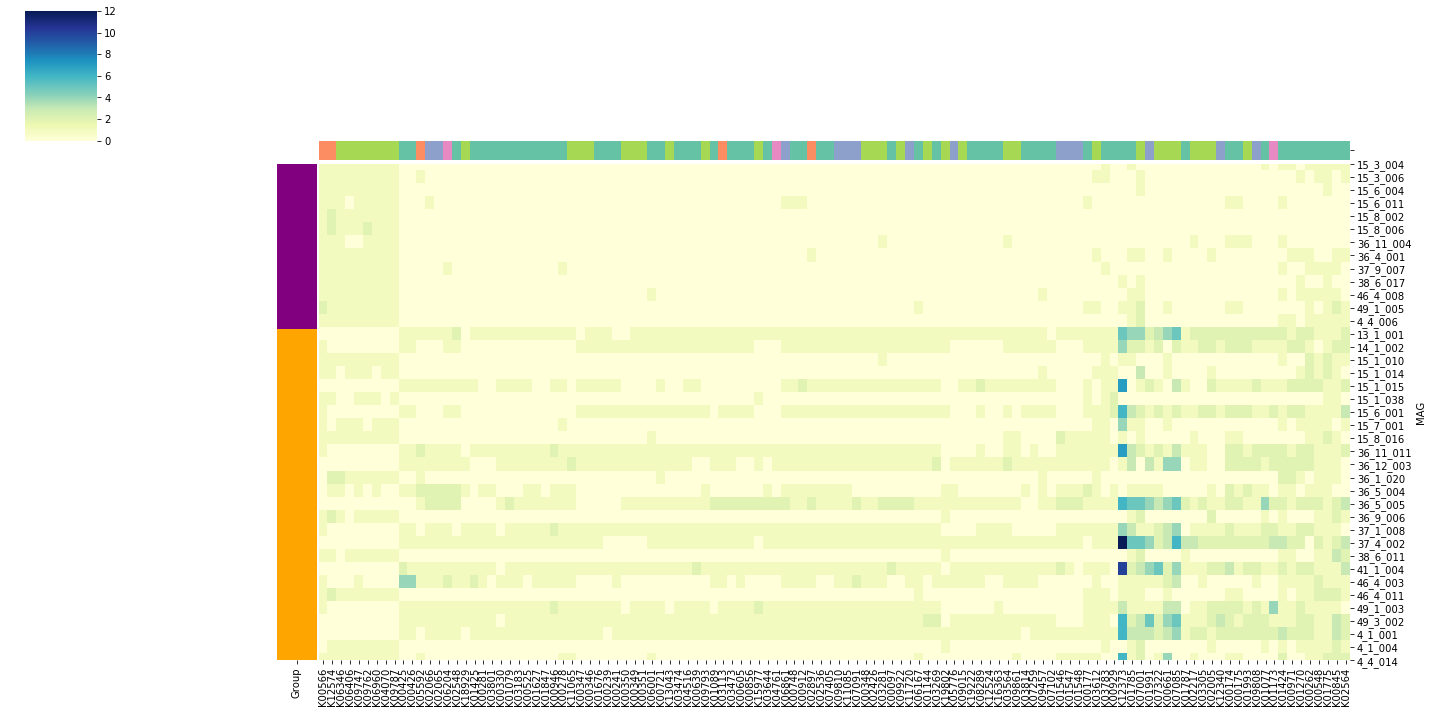

In [47]:
# Quick and dirty to check
p = sns.clustermap(df_hmap, cmap='YlGnBu', figsize=(20,10), xticklabels=True, yticklabels=True,
                   row_cluster=False, method='ward', metric='euclidean', row_colors=sample_colors, 
                   col_colors=column_colors)
p.ax_col_dendrogram.set_visible(False)

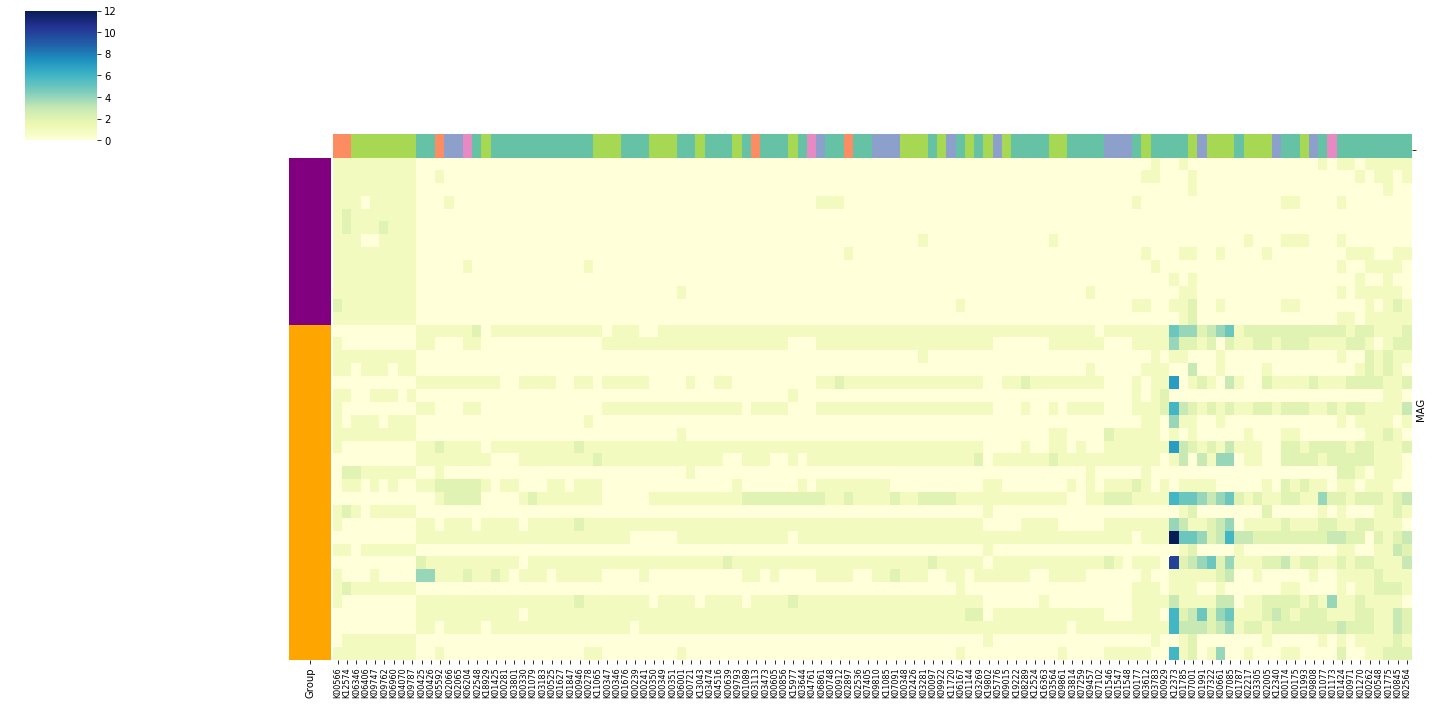

In [50]:
# Make it look pretty
# See below for sample_colors and column_colors
p = sns.clustermap(df_hmap, figsize=(20,10), cmap='YlGnBu', xticklabels=True, yticklabels=False, row_cluster=False,
                   method='ward', metric='euclidean', row_colors=sample_colors, col_colors=column_colors)
hm = p.ax_heatmap.get_position()
plt.setp(p.ax_heatmap.yaxis.get_majorticklabels(), fontsize=14)
plt.setp(p.ax_heatmap.xaxis.get_majorticklabels(), fontsize=8)
p.ax_heatmap.set_position([hm.x0, hm.y0, hm.width, hm.height])
col = p.ax_col_dendrogram.get_position()
row = p.ax_row_dendrogram.get_position()
p.ax_col_dendrogram.set_position([col.x0, col.y0, col.width, col.height])
p.ax_col_colors.set_position([col.x0, col.y0-0.04, col.width, col.height*0.25])
#p.ax_row_dendrogram.set_position([row.x0+0.07, row.y0, row.width*0.75, row.height])
p.ax_col_dendrogram.set_visible(False)

In [51]:
p.savefig("MAGs_KOs_clustermap_SDCORRECTEDp05_KOlabels.png")

### Custom legend

In [45]:
%matplotlib inline

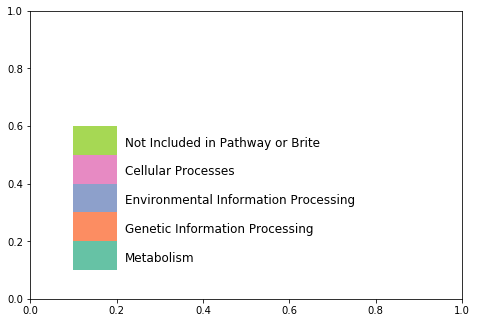

In [136]:
x, y = (0.1, 0)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
for func in kos_column_colors['Functional category'].unique():
    y = y + 0.1
    color = lut[func]
    #cat = lut3[ko]
    square = plt.Rectangle((x, y), 0.1, 0.1, fc=color)
    plt.gca().add_patch(square)
    plt.text(x + 0.12, y + 0.03, func, fontsize=12)

In [137]:
fig.savefig('fxn_labels.png')